# IBM Applied Data Science Capstone Project

**_Opening a Coffee Shop in Bangalore, India_**
- Build a dataframe of neighborhoods in Bangalore, India by modifying All India Pincode directory from data.gov.in
- Get the geographical coordinates of the neighborhoods
- Obtain the venue data for the neighborhoods from Foursquare API
- Explore and cluster the neighborhoods
- Select the best cluster to open a new coffee shop
***

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## 1. Read and Explore Dataset

In [2]:
# Loading the dataset created in prepare_bangalore_dataset.ipynb
df = pd.read_csv("bangalore.csv")

In [3]:
df.shape

(601, 6)

In [4]:
df.head()

,pincode,officename,Districtname,regionname,Latitude,Longtude
0,560063,A F Station Yelahanka S.O,Bangalore,Bangalore HQ,13.1322,77.3967
1,560007,Agram S.O,Bangalore,Bangalore HQ,13.0643,77.1260
2,560007,Air Force Hospital S.O,Bangalore,Bangalore HQ,13.0643,77.1260
3,560092,Amruthahalli B.O,Bangalore,Bangalore HQ,13.0583,77.5732
4,560024,Anandnagar S.O (Bangalore),Bangalore,Bangalore HQ,12.9714,77.5481


In [5]:
df.columns

Index(['pincode', 'officename', 'Districtname', 'regionname', 'Latitude',
       'Longtude'],
      dtype='object')

In [6]:
df.columns = ['Postcode', 'Neighbourhood', 'Districtname', 'Borough', 'Latitude', 'Longitude']

In [7]:
df.columns

Index(['Postcode', 'Neighbourhood', 'Districtname', 'Borough', 'Latitude',
       'Longitude'],
      dtype='object')

In [8]:
df.head()

,Postcode,Neighbourhood,Districtname,Borough,Latitude,Longitude
0,560063,A F Station Yelahanka S.O,Bangalore,Bangalore HQ,13.1322,77.3967
1,560007,Agram S.O,Bangalore,Bangalore HQ,13.0643,77.1260
2,560007,Air Force Hospital S.O,Bangalore,Bangalore HQ,13.0643,77.1260
3,560092,Amruthahalli B.O,Bangalore,Bangalore HQ,13.0583,77.5732
4,560024,Anandnagar S.O (Bangalore),Bangalore,Bangalore HQ,12.9714,77.5481


In [9]:
df = df[df.Districtname == 'Bangalore']

In [10]:
df.shape

(264, 6)

In [11]:
df = df[['Postcode', 'Borough', 'Neighbourhood', 'Latitude', 'Longitude']]

In [12]:
df.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,560063,Bangalore HQ,A F Station Yelahanka S.O,13.1322,77.3967
1,560007,Bangalore HQ,Agram S.O,13.0643,77.1260
2,560007,Bangalore HQ,Air Force Hospital S.O,13.0643,77.1260
3,560092,Bangalore HQ,Amruthahalli B.O,13.0583,77.5732
4,560024,Bangalore HQ,Anandnagar S.O (Bangalore),12.9714,77.5481


##### Use geopy library to get the latitude and longitude values of Bangalore City

In [16]:
address = 'Bangalore, Karnataka'

geolocator = Nominatim(user_agent="tr_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Bangalore City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Bangalore City are 12.9791198, 77.5912997.


##### Create a map of New York with neighborhoods superimposed on top.

In [17]:
# create map of Toronto using latitude and longitude values
map_bng = folium.Map(location=[latitude, longitude], zoom_start=9)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bng)  
    
map_bng

#### Define Foursquare Credentials and Version

In [18]:
CLIENT_ID = 'JWZWPU4GQ1WBMINFHG4WQIDAFAK0AEUP1KUCZV54AZ5VUQXC' # your Foursquare ID
CLIENT_SECRET = 'MPPMNJFUII4K5WRAQ40CEAYVUWTRDBIJD3KP2MEMF4LQOO4W' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: JWZWPU4GQ1WBMINFHG4WQIDAFAK0AEUP1KUCZV54AZ5VUQXC
CLIENT_SECRET:MPPMNJFUII4K5WRAQ40CEAYVUWTRDBIJD3KP2MEMF4LQOO4W


In [19]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

## 2. Explore Neighbourhoods in Bangalore

In [20]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

##### code to run the above function on each neighborhood and create a new dataframe called bng_venues.

In [22]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

bng_venues = getNearbyVenues(names=df['Neighbourhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

A F Station Yelahanka S.O
Agram S.O
Air Force Hospital S.O
Amruthahalli B.O
Anandnagar S.O (Bangalore)
Arabic College S.O
Attur B.O
Austin Town S.O
Banaswadi S.O
Bangalore Bazaar S.O
Bangalore International Airport S.O
Bangalore Sub Foreign Post S.O
Bellandur S.O
Benson Town S.O
Bhattarahalli S.O
Bidrahalli B.O
BSF Campus Yelahanka S.O
Byatarayanapura B.O
C.V.Raman Nagar S.O
CMM Court Complex S.O
CMP Centre And School S.O
CRPF Campus Yelahanka S.O
Devanagundi B.O
Devasandra S.O
Doddagubbi B.O
Doddanekkundi B.O
Domlur S.O
Doorvaninagar S.O
Dr. Ambedkar Veedhi S.O
Dr. Shivarama Karanth Nagar S.O
EPIP S.O
Fraser Town S.O
G.K.V.K. S.O
Gunjur B.O
H.A. Farm S.O
H.A.L II Stage H.O
H.K.P. Road S.O
Hebbal Kempapura S.O
HighCourt S.O
Hoodi B.O
Horamavu B.O
Hulsur Bazaar S.O
Indiranagar S.O (Bangalore)
ISRO Anthariksha Bhavan S.O
J.C.Nagar S.O
Jakkur B.O
Jalavayuvihar S.O
Jeevanbhimanagar S.O
Kadugodi Extention SO
Kadugodi S.O
Kalyananagar S.O
Kannamangala B.O
Kodigehalli B.O
Kothanur S.O
Krishna

In [32]:
print(bng_venues.shape)
bng_venues.head()

(1760, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Amruthahalli B.O,13.0583,77.5732,Needs Supermarket,13.056991,77.574203,Supermarket
1,Amruthahalli B.O,13.0583,77.5732,Social Bee India,13.061168,77.574598,Event Service
2,Amruthahalli B.O,13.0583,77.5732,chin lung,13.054561,77.573212,Bar
3,Amruthahalli B.O,13.0583,77.5732,Raj Murali Theatre,13.060574,77.576934,Movie Theater
4,Amruthahalli B.O,13.0583,77.5732,Kodigehalli Railway Station (KDGH),13.062318,77.574956,Platform


#### Let's check how many venues were returned for each neighborhood

In [33]:
bng_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Adugodi S.O,4,4,4,4,4,4
Agara B.O,4,4,4,4,4,4
Amruthahalli B.O,5,5,5,5,5,5
Anandnagar S.O (Bangalore),4,4,4,4,4,4
Anekal S.O,1,1,1,1,1,1
Ashoknagar S.O (Bangalore),8,8,8,8,8,8
Attibele S.O,3,3,3,3,3,3
Bagalur S.O (Bangalore),1,1,1,1,1,1
Banashankari III Stage S.O,8,8,8,8,8,8


#### Let's find out how many unique categories can be curated from all the returned venues

In [34]:
print('There are {} uniques categories.'.format(len(bng_venues['Venue Category'].unique())))

There are 126 uniques categories.


## 3. Analyze Each Neighbourhood

In [35]:
# one hot encoding
bng_onehot = pd.get_dummies(bng_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
bng_onehot['Neighborhood'] = bng_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [bng_onehot.columns[-1]] + list(bng_onehot.columns[:-1])
bng_onehot = bng_onehot[fixed_columns]

bng_onehot.head()

,Neighborhood,ATM,American Restaurant,Andhra Restaurant,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Auto Garage,BBQ Joint,Badminton Court,Bakery,Bar,Bed & Breakfast,Bike Shop,Bistro,Bookstore,Boutique,Breakfast Spot,Brewery,Burger Joint,Bus Station,Café,Candy Store,Cantonese Restaurant,Chaat Place,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Convenience Store,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Electronics Store,Event Service,Fast Food Restaurant,Flea Market,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Gastropub,Grocery Store,Gym,Gym / Fitness Center,Health Food Store,Hockey Arena,Hotel,Hotel Bar,Hotel Pool,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karnataka Restaurant,Kerala Restaurant,Lake,Liquor Store,Lounge,Market,Mediterranean Restaurant,Memorial Site,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Music Venue,North Indian Restaurant,Optical Shop,Outlet Store,Pakistani Restaurant,Park,Parsi Restaurant,Pharmacy,Pizza Place,Platform,Playground,Pool,Pool Hall,Print Shop,Pub,Racetrack,Rajasthani Restaurant,Restaurant,Salad Place,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shopping Mall,Smoke Shop,Snack Place,Soccer Field,South Indian Restaurant,Southern / Soul Food Restaurant,Sports Bar,Sports Club,Stadium,Steakhouse,Supermarket,Tea Room,Tennis Stadium,Toll Plaza,Toy / Game Store,Track Stadium,Udupi Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Yoga Studio,Zoo
0,Amruthahalli B.O,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,Amruthahalli B.O,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Amruthahalli B.O,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Amruthahalli B.O,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Amruthahalli B.O,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [36]:
bng_onehot.shape

(1760, 127)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [37]:
bng_grouped = bng_onehot.groupby('Neighborhood').mean().reset_index()
bng_grouped

,Neighborhood,ATM,American Restaurant,Andhra Restaurant,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Auto Garage,BBQ Joint,Badminton Court,Bakery,Bar,Bed & Breakfast,Bike Shop,Bistro,Bookstore,Boutique,Breakfast Spot,Brewery,Burger Joint,Bus Station,Café,Candy Store,Cantonese Restaurant,Chaat Place,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Convenience Store,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Electronics Store,Event Service,Fast Food Restaurant,Flea Market,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Gastropub,Grocery Store,Gym,Gym / Fitness Center,Health Food Store,Hockey Arena,Hotel,Hotel Bar,Hotel Pool,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karnataka Restaurant,Kerala Restaurant,Lake,Liquor Store,Lounge,Market,Mediterranean Restaurant,Memorial Site,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Music Venue,North Indian Restaurant,Optical Shop,Outlet Store,Pakistani Restaurant,Park,Parsi Restaurant,Pharmacy,Pizza Place,Platform,Playground,Pool,Pool Hall,Print Shop,Pub,Racetrack,Rajasthani Restaurant,Restaurant,Salad Place,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shopping Mall,Smoke Shop,Snack Place,Soccer Field,South Indian Restaurant,Southern / Soul Food Restaurant,Sports Bar,Sports Club,Stadium,Steakhouse,Supermarket,Tea Room,Tennis Stadium,Toll Plaza,Toy / Game Store,Track Stadium,Udupi Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Yoga Studio,Zoo
0,Adugodi S.O,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.25,0.000000,0.000000,0.000000,0.0,0.250000,0.000000,0.0000,0.0,0.000000,0.0,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1,Agara B.O,0.25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0000,0.0,0.000000,0.0,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000,0.0,0.000000,0.00,0.000000,0.000000,0.250000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2,Amruthahalli B.O,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.200000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000

In [38]:
bng_grouped.shape

(192, 127)

#### Let's print each neighborhood along with the top 5 most common venues

In [39]:
num_top_venues = 5

for hood in bng_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = bng_grouped[bng_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adugodi S.O----
                  venue  freq
0         Design Studio  0.25
1           Bus Station  0.25
2     Indian Restaurant  0.25
3  Fast Food Restaurant  0.25
4                   ATM  0.00


----Agara B.O----
           venue  freq
0            ATM  0.25
1    Coffee Shop  0.25
2       Pharmacy  0.25
3    Sports Club  0.25
4  Moving Target  0.00


----Amruthahalli B.O----
           venue  freq
0  Movie Theater   0.2
1       Platform   0.2
2  Event Service   0.2
3    Supermarket   0.2
4            Bar   0.2


----Anandnagar S.O (Bangalore)----
                  venue  freq
0      Department Store  0.25
1  Fast Food Restaurant  0.25
2         Shopping Mall  0.25
3             Multiplex  0.25
4                   ATM  0.00


----Anekal S.O----
           venue  freq
0            ATM   1.0
1  Movie Theater   0.0
2     Playground   0.0
3       Platform   0.0
4    Pizza Place   0.0


----Ashoknagar S.O (Bangalore)----
               venue  freq
0  Indian Restaurant  0.38
1       Co

                venue  freq
0   Indian Restaurant  0.25
1               Hotel  0.19
2              Garden  0.06
3          Food Court  0.06
4  Seafood Restaurant  0.06


----Devasandra S.O----
               venue  freq
0               Café  0.33
1  Mobile Phone Shop  0.33
2       Soccer Field  0.33
3                ATM  0.00
4          Multiplex  0.00


----Dharmaram College S.O----
            venue  freq
0  Scenic Lookout   1.0
1             ATM   0.0
2       Pool Hall   0.0
3      Playground   0.0
4        Platform   0.0


----Doddajala B.O----
               venue  freq
0  Indian Restaurant  0.50
1               Lake  0.25
2        Coffee Shop  0.25
3                ATM  0.00
4               Park  0.00


----Doddanekkundi B.O----
               venue  freq
0               Café  0.33
1  Mobile Phone Shop  0.33
2       Soccer Field  0.33
3                ATM  0.00
4          Multiplex  0.00


----Domlur S.O----
                   venue  freq
0      Indian Restaurant  0.21
1         

                           venue  freq
0  Vegetarian / Vegan Restaurant  0.33
1              Indian Restaurant  0.33
2           Fast Food Restaurant  0.17
3                           Café  0.17
4                            ATM  0.00


----Jigani S.O----
           venue  freq
0         Bakery   1.0
1            ATM   0.0
2  Moving Target   0.0
3           Pool   0.0
4     Playground   0.0


----Kadugodi Extention SO----
                venue  freq
0   Indian Restaurant  0.25
1               Hotel  0.19
2              Garden  0.06
3          Food Court  0.06
4  Seafood Restaurant  0.06


----Kadugodi S.O----
                venue  freq
0   Indian Restaurant  0.25
1               Hotel  0.19
2              Garden  0.06
3          Food Court  0.06
4  Seafood Restaurant  0.06


----Kallubalu B.O----
           venue  freq
0         Bakery   1.0
1            ATM   0.0
2  Moving Target   0.0
3           Pool   0.0
4     Playground   0.0


----Kalyananagar S.O----
               venue  freq


                           venue  freq
0                           Park  0.33
1  Vegetarian / Vegan Restaurant  0.33
2                         Bakery  0.33
3           Pakistani Restaurant  0.00
4                      Multiplex  0.00


----Nayandahalli S.O----
               venue  freq
0               Café  0.33
1  Mobile Phone Shop  0.33
2       Soccer Field  0.33
3                ATM  0.00
4          Multiplex  0.00


----Neralur B.O----
                     venue  freq
0              Bus Station  0.33
1        Indian Restaurant  0.33
2  South Indian Restaurant  0.33
3                      ATM  0.00
4             Outlet Store  0.00


----Neriga B.O----
           venue  freq
0   Optical Shop   0.1
1     Food Truck   0.1
2           Café   0.1
3  Moving Target   0.1
4    Pizza Place   0.1


----P&T Col. Kavalbyrasandra S.O----
               venue  freq
0               Café  0.33
1  Mobile Phone Shop  0.33
2       Soccer Field  0.33
3                ATM  0.00
4          Multiplex  0.

           venue  freq
0  Movie Theater   0.2
1       Platform   0.2
2  Event Service   0.2
3    Supermarket   0.2
4            Bar   0.2


----Vanakanahalli B.O----
           venue  freq
0            ATM   1.0
1  Movie Theater   0.0
2     Playground   0.0
3       Platform   0.0
4    Pizza Place   0.0


----Vasanthanagar S.O----
                venue  freq
0   Indian Restaurant  0.26
1         Coffee Shop  0.10
2  Italian Restaurant  0.06
3  Chinese Restaurant  0.06
4           Pool Hall  0.03


----Vidhana Soudha S.O----
                venue  freq
0   Indian Restaurant  0.26
1         Coffee Shop  0.10
2  Italian Restaurant  0.06
3  Chinese Restaurant  0.06
4           Pool Hall  0.03


----Vidyanagara B.O----
               venue  freq
0  Indian Restaurant  0.50
1               Lake  0.25
2        Coffee Shop  0.25
3                ATM  0.00
4               Park  0.00


----Vidyaranyapura S.O----
               venue  freq
0        Pizza Place  0.17
1        Snack Place  0.17
2  Co

#### Let's put that into a pandas dataframe

In [40]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [41]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = bng_grouped['Neighborhood']

for ind in np.arange(bng_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(bng_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adugodi S.O,Indian Restaurant,Design Studio,Fast Food Restaurant,Bus Station,Zoo,French Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop
1,Agara B.O,ATM,Coffee Shop,Pharmacy,Sports Club,Electronics Store,Food Court,Flea Market,Fast Food Restaurant,Event Service,Dessert Shop
2,Amruthahalli B.O,Platform,Movie Theater,Bar,Event Service,Supermarket,Electronics Store,Flea Market,Fast Food Restaurant,Diner,Food Truck
3,Anandnagar S.O (Bangalore),Department Store,Fast Food Restaurant,Multiplex,Shopping Mall,Zoo,Convenience Store,Dance Studio,Deli / Bodega,Design Studio,Dessert Shop
4,Anekal S.O,ATM,Fried Chicken Joint,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Electronics Store,Event Service


In [72]:
len(bng_grouped[bng_grouped["Coffee Shop"] > 0])

54

#### Create a new DataFrame for Coffee Shop data only

In [73]:
bng_coffee = bng_grouped[["Neighborhood","Coffee Shop"]]

In [74]:
bng_coffee.head()

,Neighborhood,Coffee Shop
0,Adugodi S.O,0.00
1,Agara B.O,0.25
2,Amruthahalli B.O,0.00
3,Anandnagar S.O (Bangalore),0.00
4,Anekal S.O,0.00


## 4. Cluster Neighbourhoods

### Finding optimal k using elbow method

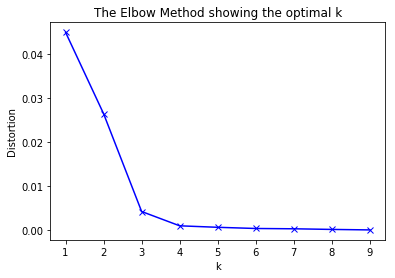

In [75]:
# clustering dataset
# determine k using elbow method

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt


# create new plot and data
# plt.plot()
X = bng_coffee.drop('Neighborhood', 1)
# colors = ['b', 'g', 'r']
# markers = ['o', 'v', 's']

# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [76]:
# set number of clusters
kclusters = 4

bng_clustering =bng_coffee.drop(["Neighborhood"], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bng_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

In [77]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
bng_merged = bng_coffee.copy()

# add clustering labels
bng_merged["Cluster Labels"] = kmeans.labels_

In [78]:
bng_merged.head()

,Neighborhood,Coffee Shop,Cluster Labels
0,Adugodi S.O,0.00,0
1,Agara B.O,0.25,1
2,Amruthahalli B.O,0.00,0
3,Anandnagar S.O (Bangalore),0.00,0
4,Anekal S.O,0.00,0


In [79]:
# merge bng_grouped with toronto_data to add latitude/longitude for each neighborhood
bng_merged = bng_merged.join(df.set_index("Neighbourhood"), on="Neighborhood")

print(bng_merged.shape)
bng_merged.head() # check the last columns!

(192, 7)


,Neighborhood,Coffee Shop,Cluster Labels,Postcode,Borough,Latitude,Longitude
0,Adugodi S.O,0.00,0,560030,Bangalore HQ,12.9440,77.6079
1,Agara B.O,0.25,1,560034,Bangalore HQ,13.0381,77.6549
2,Amruthahalli B.O,0.00,0,560092,Bangalore HQ,13.0583,77.5732
3,Anandnagar S.O (Bangalore),0.00,0,560024,Bangalore HQ,12.9714,77.5481
4,Anekal S.O,0.00,0,562106,Bangalore HQ,12.7111,77.6956


In [80]:
# sort the results by Cluster Labels
print(bng_merged.shape)
bng_merged.sort_values(["Cluster Labels"], inplace=True)
bng_merged

(192, 7)


,Neighborhood,Coffee Shop,Cluster Labels,Postcode,Borough,Latitude,Longitude
0,Adugodi S.O,0.000000,0,560030,Bangalore HQ,12.9440,77.6079
110,Magadi Road S.O,0.000000,0,560023,Bangalore HQ,12.9750,77.5489
111,Mahadevapura S.O,0.000000,0,560048,Bangalore HQ,12.9944,77.7164
112,Mahalakshmipuram Layout S.O,0.000000,0,560086,Bangalore HQ,12.9872,77.5244
114,Mallathahalli B.O,0.000000,0,560056,Bangalore HQ,12.9979,77.5861
115,Malleswaram S.O,0.000000,0,560003,Bangalore HQ,13.0097,77.5648
116,Malleswaram West S.O,0.000000,0,560055,Bangalore HQ,12.9979,77.5861
117,Marathahalli Colony S.O,0.000000,0,560037,Bangalore HQ,12.9855,77.6344
109,Madivala S.O,0.000000,0,560068,Bangalore HQ,12.9079,77.6285
118,Marsur B.O,0.000000,0,562106,Bangalore HQ,12.7111,77.6956


#### Finally, let's visualize the resulting clusters

In [81]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(bng_merged['Latitude'], bng_merged['Longitude'], bng_merged['Neighborhood'], bng_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [82]:
# save the map as HTML file
map_clusters.save('map_clusters.html')

## 5. Examine Clusters

### Cluster 1

In [83]:
bng_merged.loc[bng_merged['Cluster Labels'] == 0]

,Neighborhood,Coffee Shop,Cluster Labels,Postcode,Borough,Latitude,Longitude
0,Adugodi S.O,0.0,0,560030,Bangalore HQ,12.9440,77.6079
110,Magadi Road S.O,0.0,0,560023,Bangalore HQ,12.9750,77.5489
111,Mahadevapura S.O,0.0,0,560048,Bangalore HQ,12.9944,77.7164
112,Mahalakshmipuram Layout S.O,0.0,0,560086,Bangalore HQ,12.9872,77.5244
114,Mallathahalli B.O,0.0,0,560056,Bangalore HQ,12.9979,77.5861
115,Malleswaram S.O,0.0,0,560003,Bangalore HQ,13.0097,77.5648
116,Malleswaram West S.O,0.0,0,560055,Bangalore HQ,12.9979,77.5861
117,Marathahalli Colony S.O,0.0,0,560037,Bangalore HQ,12.9855,77.6344
109,Madivala S.O,0.0,0,560068,Bangalore HQ,12.9079,77.6285
118,Marsur B.O,0.0,0,562106,Bangalore HQ,12.7111,77.6956


### Cluster 2

In [84]:
bng_merged.loc[bng_merged['Cluster Labels'] == 1]

,Neighborhood,Coffee Shop,Cluster Labels,Postcode,Borough,Latitude,Longitude
179,Vidyanagara B.O,0.250000,1,562157,Bangalore HQ,13.1438,77.6169
73,Hunasamaranahalli B.O,0.250000,1,562157,Bangalore HQ,13.1438,77.6169
23,Bettahalsur S.O,0.250000,1,562157,Bangalore HQ,13.1438,77.6169
1,Agara B.O,0.250000,1,560034,Bangalore HQ,13.0381,77.6549
97,Koramangala I Block S.O,0.250000,1,560034,Bangalore HQ,13.0381,77.6549
98,Koramangala S.O,0.250000,1,560034,Bangalore HQ,13.0381,77.6549
169,Tarahunise B.O,0.250000,1,562157,Bangalore HQ,13.1438,77.6169
164,St. John's Medical College S.O,0.250000,1,560034,Bangalore HQ,13.0381,77.6549
153,Sadashivanagar S.O,0.214286,1,560080,Bangalore HQ,13.0104,77.5806
47,Doddajala B.O,0.250000,1,562157,Bangalore HQ,13.1438,77.6169


### Cluster 3

In [85]:
bng_merged.loc[bng_merged['Cluster Labels'] == 2]

,Neighborhood,Coffee Shop,Cluster Labels,Postcode,Borough,Latitude,Longitude
63,Handenahalli B.O,0.100000,2,562125,Bangalore HQ,12.9247,77.6496
50,Dommasandra B.O,0.100000,2,562125,Bangalore HQ,12.9247,77.6496
113,Mahatma Gandhi Road S.O,0.096774,2,560001,Bangalore HQ,12.9914,77.5944
186,Wilson Garden S.O,0.090909,2,560027,Bangalore HQ,12.9506,77.5952
178,Vidhana Soudha S.O,0.096774,2,560001,Bangalore HQ,12.9914,77.5944
177,Vasanthanagar S.O,0.096774,2,560001,Bangalore HQ,12.9914,77.5944
12,Bangalore Bazaar S.O,0.096774,2,560001,Bangalore HQ,12.9914,77.5944
102,Kugur B.O,0.100000,2,562125,Bangalore HQ,12.9247,77.6496
15,Bangalore G.P.O.,0.096774,2,560001,Bangalore HQ,12.9914,77.5944
135,Neriga B.O,0.100000,2,562125,Bangalore HQ,12.9247,77.6496


### Cluster 4

In [87]:
bng_merged.loc[bng_merged['Cluster Labels'] == 3]

,Neighborhood,Coffee Shop,Cluster Labels,Postcode,Borough,Latitude,Longitude
121,Mavalli S.O,0.062500,3,560004,Bangalore HQ,12.9833,77.5833
35,CMP Centre And School S.O,0.066667,3,560025,Bangalore HQ,12.9634,77.6025
151,Richmond Town S.O,0.066667,3,560025,Bangalore HQ,12.9634,77.6025
123,Medimallasandra B.O,0.062500,3,560067,Bangalore HQ,12.9833,77.5833
124,Mico Layout S.O,0.062500,3,560076,Bangalore HQ,12.9833,77.5833
182,Virgonagar S.O,0.062500,3,560049,Bangalore HQ,12.9833,77.5833
125,Mount St Joseph B.O,0.062500,3,560076,Bangalore HQ,12.9833,77.5833
88,Kadugodi Extention SO,0.062500,3,560067,Bangalore HQ,12.9833,77.5833
127,Mundur B.O,0.062500,3,560049,Bangalore HQ,12.9833,77.5833
26,Bidrahalli B.O,0.062500,3,560049,Bangalore HQ,12.9833,77.5833


#### Observations:
Most of the coffee shops are concentrated, with the highest number in cluster 2 and moderate number in cluster 3. On the other hand, cluster 4 has very low number of coffee shops and cluster 1 has totally no coffee shop in the neighborhoods. This represents a great opportunity and high potential areas to open new coffee shops as there is very little to no competition from existing coffee shops. Meanwhile, coffee shops in cluster 2 are likely suffering from intense competition due to oversupply and high concentration of coffee shops. From another perspective, this also shows that the oversupply of coffee shops mostly happened in the central area of the city, with the suburb area still have very few coffee shops. Therefore, this project recommends property developers to capitalize on these findings to open new coffee shops in neighborhoods in cluster 1 and 4 with little to no competition. Property developers with unique selling propositions to stand out from the competition can also open new coffee shops in neighborhoods in cluster 3 with moderate competition. Lastly, property developers are advised to avoid neighborhoods in cluster 2 which already have high concentration of coffee shops and suffering from intense competition.